成功预处理 38 场洪水事件。

各类别洪水事件数量:
  Small 洪水: 13 场
  Medium 洪水: 12 场
  Large 洪水: 13 场

--- 正在为组 'small' 优化特征单位线 (13 场) ---
  单位线长度: 49
  使用权重: 平滑=0.1, 单峰罚=100.0
  优化成功

--- 正在为组 'medium' 优化特征单位线 (12 场) ---
  单位线长度: 51
  使用权重: 平滑=0.5, 单峰罚=500.0
  优化成功

--- 正在为组 'large' 优化特征单位线 (13 场) ---
  单位线长度: 55
  使用权重: 平滑=1.0, 单峰罚=1000.0
  优化成功

--- 正在为类别 'Small' 绘制最佳/最差拟合图 ---


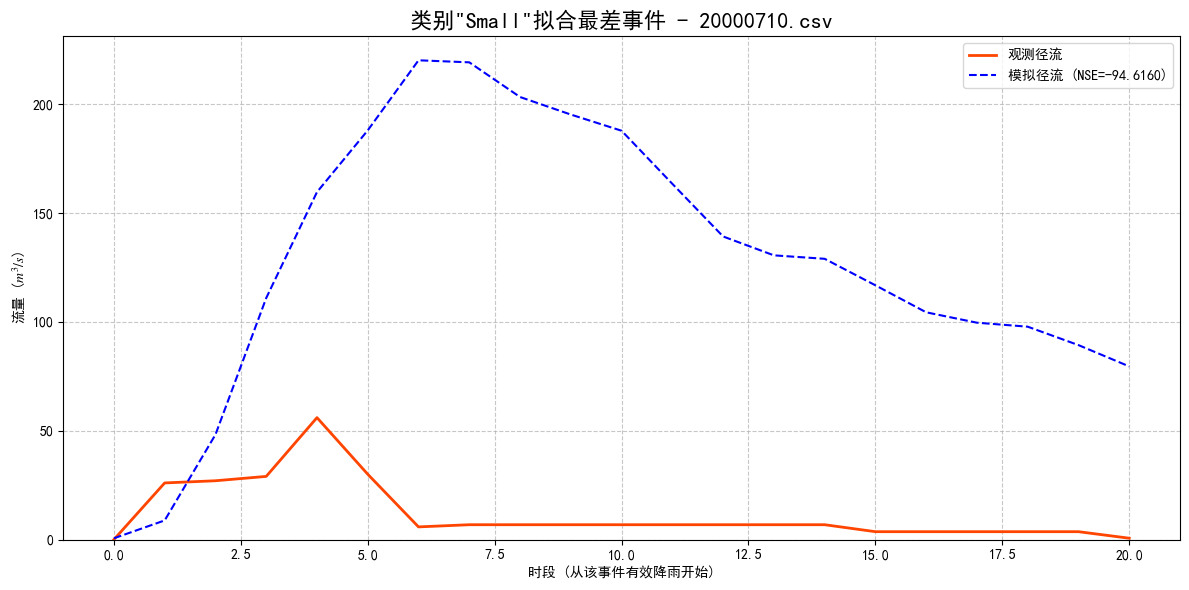

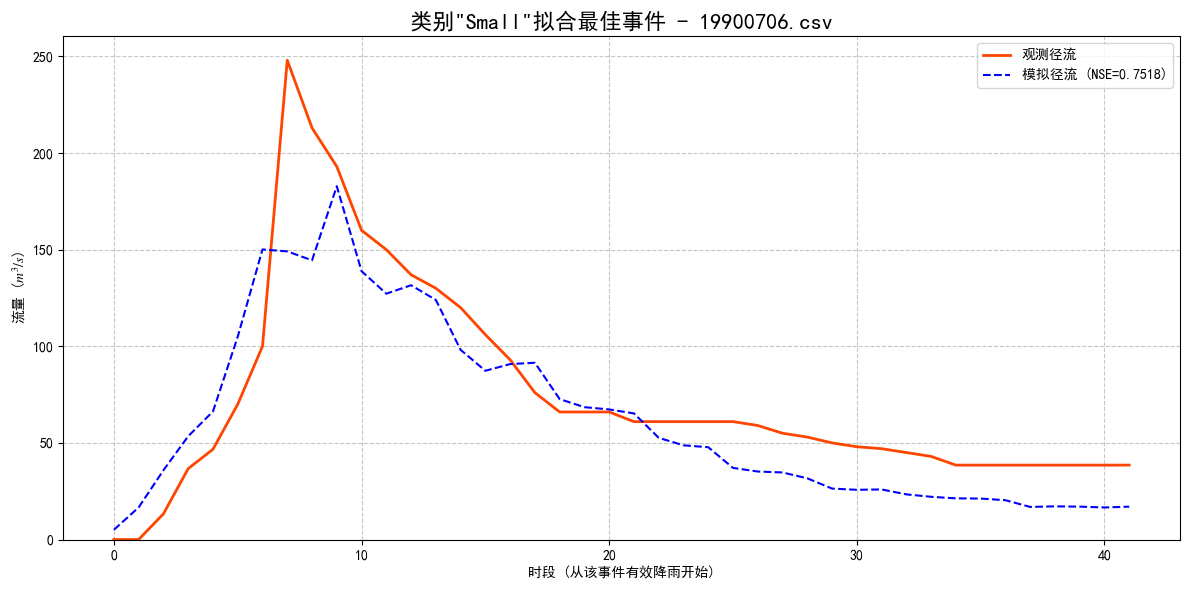


--- 正在为类别 'Medium' 绘制最佳/最差拟合图 ---


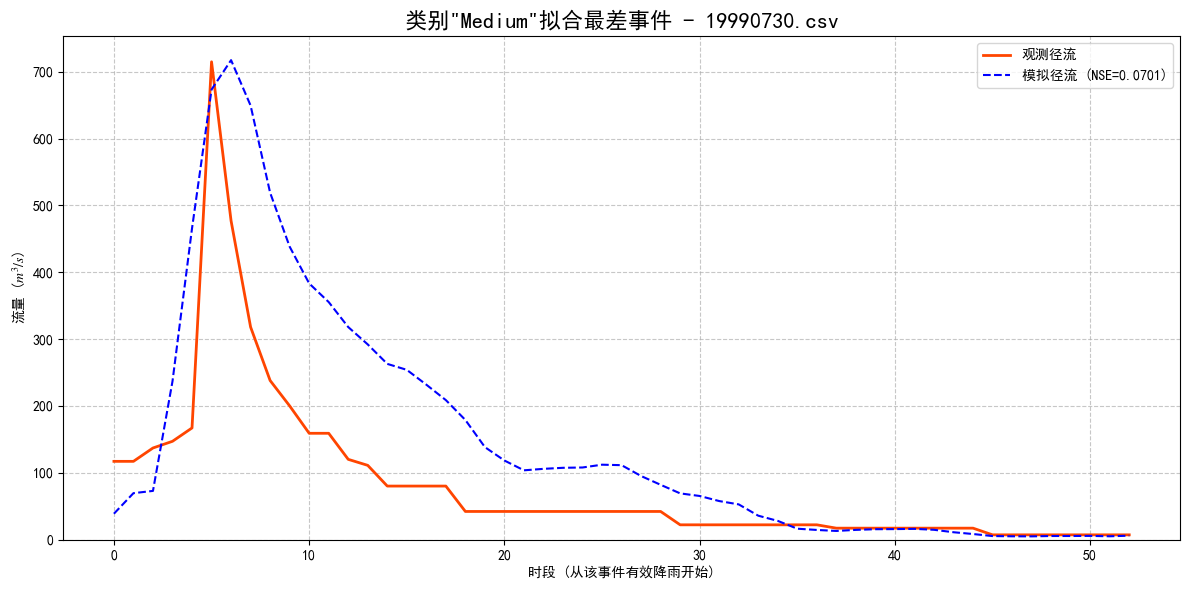

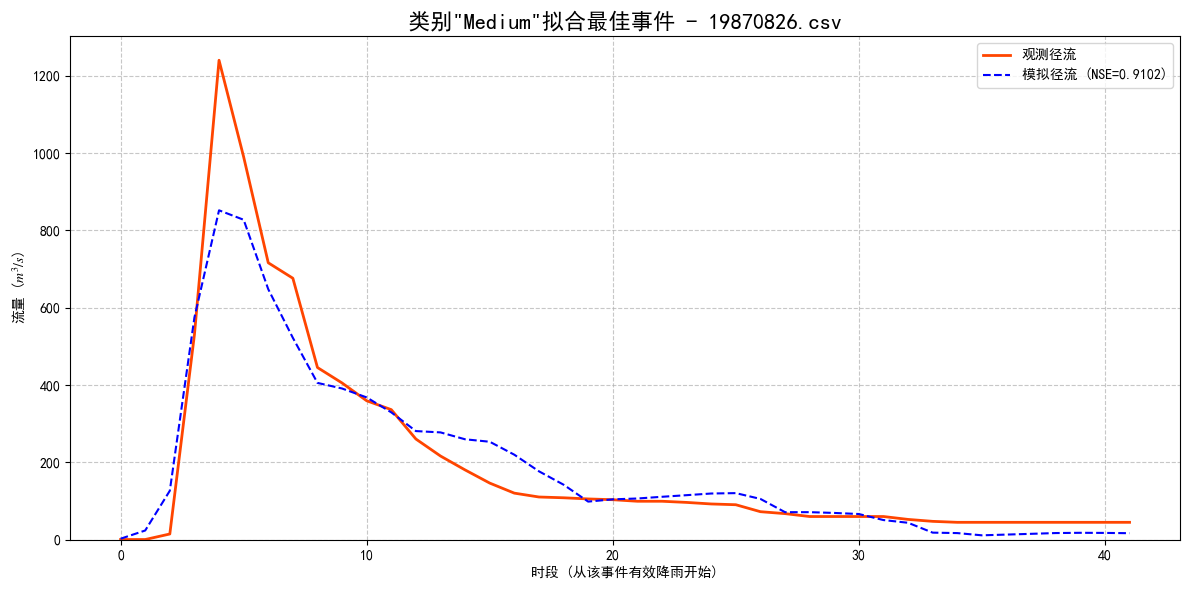


--- 正在为类别 'Large' 绘制最佳/最差拟合图 ---


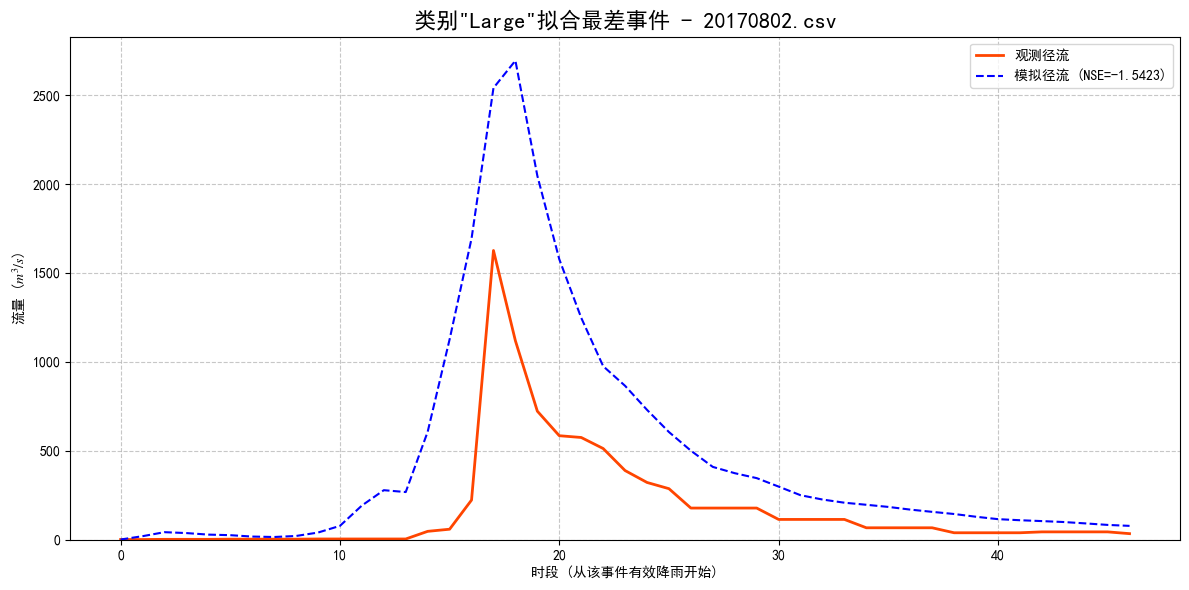

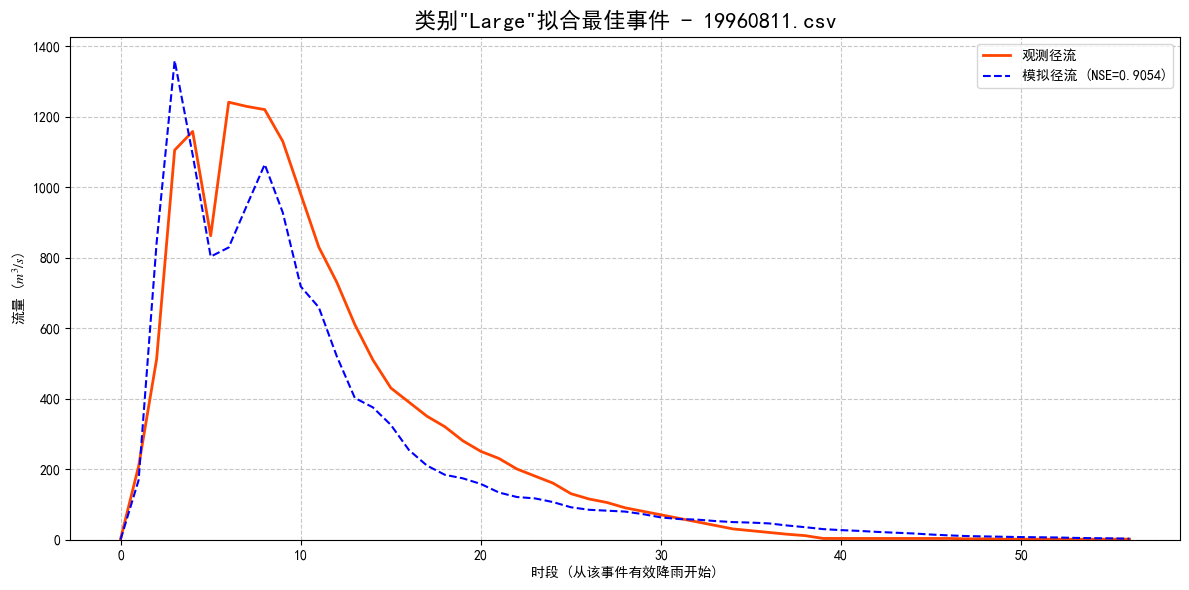

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("中文字体 SimHei 未找到，请确保已安装或修改字体设置。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 全局常量 ---
R_UH = 10.0
DELTA_T_HOURS = 3.0

# --- 辅助函数 ---
def preprocess_single_event_data(csv_filepath):
    """读取并处理单个洪水事件"""
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None;
        for enc in encodings_to_try:
            try: df = pd.read_csv(csv_filepath, encoding=enc); break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None
    time_col, net_rain_col, direct_runoff_col = '时间', '泰森多边形面雨量', '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None
    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    if np.sum(net_rain) < 1e-6: return None
    
    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain):
        if r_val > 1e-6: first_rain_idx, has_effective_rain = i, True; break
    if not has_effective_rain: return None
    last_rain_idx = len(net_rain) - 1
    for i in range(len(net_rain) - 1, first_rain_idx - 1, -1):
        if net_rain[i] > 1e-6: last_rain_idx = i; break
        
    P_eff_event = net_rain[first_rain_idx : last_rain_idx + 1]
    m_eff_event = len(P_eff_event)
    if m_eff_event == 0: return None
    Q_obs_eff_event = direct_runoff[first_rain_idx:]
    l_obs_eff_event = len(Q_obs_eff_event)
    n_event_specific = l_obs_eff_event - m_eff_event + 1
    if n_event_specific <= 0: return None
        
    peak_flow = np.max(direct_runoff)
    if peak_flow < 1e-6: return None
    
    return {"P_eff": P_eff_event, "Q_obs_eff": Q_obs_eff_event, "m_eff": m_eff_event, 
            "n_specific": n_event_specific, "filepath": csv_filepath, "peak_obs": peak_flow}

def convolve_uh(P, U, R_UH_val):
    """离散卷积函数"""
    m_p, n_u = len(P), len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh_for_category):
    """多事件目标函数"""
    total_fit_loss = 0
    if len(U_params) != common_n_uh_for_category: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

def optimize_uh_for_group(events_in_group, group_name, weights):
    """对指定事件组进行单位线优化"""
    print(f"\n--- 正在为组 '{group_name}' 优化特征单位线 ({len(events_in_group)} 场) ---")
    if len(events_in_group) < 3:
        print("事件数量过少，跳过优化。")
        return None
    
    n_specifics = [d["n_specific"] for d in events_in_group if d["n_specific"] > 0]
    if not n_specifics: return None
    
    n_uh_group = int(np.max(n_specifics))
    if n_uh_group <= 1: n_uh_group = max(3, n_uh_group if n_uh_group > 0 else 3)
    print(f"  单位线长度: {n_uh_group}")

    data_for_opt_group = []
    for event in events_in_group:
        P_eff, Q_obs_eff, m_eff = event["P_eff"], event["Q_obs_eff"], event["m_eff"]
        target_q_len = m_eff + n_uh_group - 1
        if target_q_len < 0: target_q_len = 0
        Q_obs_for_opt = np.zeros(target_q_len)
        len_to_copy = min(len(Q_obs_eff), target_q_len)
        Q_obs_for_opt[:len_to_copy] = Q_obs_eff[:len_to_copy]
        data_for_opt_group.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt})
    
    U_initial = np.zeros(n_uh_group)
    bounds = [(0, None) for _ in range(n_uh_group)]
    smoothing, peak_penalty = weights['smoothing_factor'], weights['peak_violation_weight']
    apply_penalty = n_uh_group > 2
    print(f"  使用权重: 平滑={smoothing}, 单峰罚={peak_penalty if apply_penalty else 'N/A'}")

    result_uh = minimize(
        objective_function_multi_event, U_initial,
        args=(data_for_opt_group, R_UH, smoothing, peak_penalty, apply_penalty, n_uh_group),
        method='L-BFGS-B', bounds=bounds,
        options={'disp': False, 'maxiter': 500}
    )
    
    U_optimized = result_uh.x if (result_uh.success or result_uh.status in [0,2]) else None
    status_message = "成功" if (result_uh.success or result_uh.status in [0,2]) else "可能未收敛"
    print(f"  优化{status_message}")
    
    return U_optimized

def calculate_nse(q_obs, q_sim):
    """计算NSE值"""
    if len(q_obs) != len(q_sim) or len(q_obs) == 0: return np.nan
    mean_obs = np.mean(q_obs)
    denominator = np.sum((q_obs - mean_obs)**2)
    if denominator == 0: return 1.0 if np.allclose(q_sim, q_obs) else -np.inf
    else: return 1 - (np.sum((q_obs - q_sim)**2) / denominator)

def plot_fit_comparison(event_data, U_optimized, plot_title, nse_value):
    """为单个事件绘制拟合对比图"""
    P_event, Q_obs_event = event_data["P_eff"], event_data["Q_obs_eff"]
    event_filename = os.path.basename(event_data["filepath"])
    
    Q_sim_full = convolve_uh(P_event, U_optimized, R_UH)
    Q_sim_plot = Q_sim_full[:len(Q_obs_event)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(Q_obs_event)), Q_obs_event, label='观测径流', color='orangered', linewidth=2)
    plt.plot(np.arange(len(Q_sim_plot)), Q_sim_plot, label=f'模拟径流 (NSE={nse_value:.4f})', color='blue', linestyle='--')
    
    plt.title(f'{plot_title} - {event_filename}', fontsize=16)
    plt.xlabel('时段 (从该事件有效降雨开始)')
    plt.ylabel(r'流量 ($m^3/s$)')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.7); plt.ylim(bottom=0); plt.tight_layout(); plt.show()

# --- 主程序 ---
if __name__ == "__main__":
    # 1. & 2. 数据预处理和分类
    data_folder = "data_source/" 
    try:
        csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
        if not csv_files: exit()
    except FileNotFoundError: exit()
    all_events_processed_data = [d for d in [preprocess_single_event_data(f) for f in csv_files] if d]
    if not all_events_processed_data: exit()
    print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

    event_peaks = [data['peak_obs'] for data in all_events_processed_data if data['peak_obs'] > 0]
    if not event_peaks: exit()
    threshold_low = np.percentile(event_peaks, 33.3)
    threshold_high = np.percentile(event_peaks, 66.6)
    categorized_events = {'small': [], 'medium': [], 'large': []}
    for event_data in all_events_processed_data:
        peak = event_data['peak_obs']
        if peak <= threshold_low: categorized_events['small'].append(event_data)
        elif peak <= threshold_high: categorized_events['medium'].append(event_data)
        else: categorized_events['large'].append(event_data)
    print("\n各类别洪水事件数量:")
    for category, events in categorized_events.items(): print(f"  {category.capitalize()} 洪水: {len(events)} 场")

    # 3. 为每个类别推求特征单位线
    category_weights = {
        'small':  {'smoothing_factor': 0.1, 'peak_violation_weight': 100.0},
        'medium': {'smoothing_factor': 0.5, 'peak_violation_weight': 500.0},
        'large':  {'smoothing_factor': 1.0, 'peak_violation_weight': 1000.0}
    }
    optimized_uhs = {}
    for category_name, events in categorized_events.items():
        weights = category_weights.get(category_name, {})
        optimized_uhs[category_name] = optimize_uh_for_group(events, category_name, weights)

    # 4. 评估并为每个类别绘制最差和最好的拟合图
    for category_name, events_in_category in categorized_events.items():
        U_optimized_cat = optimized_uhs.get(category_name)
        if U_optimized_cat is None:
            print(f"\n类别 '{category_name}' 没有可用的特征单位线，跳过绘图。")
            continue

        # 计算该类别内所有事件的NSE
        category_event_analysis = []
        for event_data in events_in_category:
            P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
            Q_sim_event_full = convolve_uh(P_event, U_optimized_cat, R_UH)
            Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
            nse_event = calculate_nse(Q_obs_event_full, Q_sim_event_compare)
            category_event_analysis.append({"filepath": event_data["filepath"], "NSE": nse_event})

        # 按NSE从小到大排序
        category_event_analysis_sorted = sorted(category_event_analysis, 
                                                key=lambda x: x["NSE"] if pd.notna(x["NSE"]) and np.isfinite(x["NSE"]) else float('-inf'))
        
        # 筛选出有效的评估结果
        valid_results = [res for res in category_event_analysis_sorted if pd.notna(res["NSE"]) and np.isfinite(res["NSE"])]

        if len(valid_results) > 0:
            print(f"\n--- 正在为类别 '{category_name.capitalize()}' 绘制最佳/最差拟合图 ---")
            
            # 获取并绘制拟合效果最差的一场
            worst_fit_event_info = valid_results[0]
            worst_event_data = next((data for data in events_in_category if data["filepath"] == worst_fit_event_info["filepath"]), None)
            if worst_event_data:
                plot_fit_comparison(worst_event_data, U_optimized_cat, f'类别"{category_name.capitalize()}"拟合最差事件', worst_fit_event_info["NSE"])

            # 获取并绘制拟合效果最好的一场 (如果多于一场，避免与最差的重复)
            if len(valid_results) > 1:
                best_fit_event_info = valid_results[-1]
                best_event_data = next((data for data in events_in_category if data["filepath"] == best_fit_event_info["filepath"]), None)
                if best_event_data:
                    plot_fit_comparison(best_event_data, U_optimized_cat, f'类别"{category_name.capitalize()}"拟合最佳事件', best_fit_event_info["NSE"])
            elif len(valid_results) == 1:
                 print(f"  (类别 '{category_name.capitalize()}' 只有一个有效事件，因此最佳和最差是同一个)")
        else:
            print(f"类别 '{category_name}' 没有可供评估的有效洪水事件。")

成功预处理 38 场洪水事件。

各类别洪水事件数量:
  Small 洪水: 13 场
  Medium 洪水: 12 场
  Large 洪水: 13 场

--- 正在为组 'small' 优化特征单位线 (13 场) ---
  单位线长度: 49
  使用权重: 平滑=0.1, 单峰罚=100.0
  优化成功

--- 正在为组 'medium' 优化特征单位线 (12 场) ---
  单位线长度: 51
  使用权重: 平滑=0.5, 单峰罚=500.0
  优化成功

--- 正在为组 'large' 优化特征单位线 (13 场) ---
  单位线长度: 55
  使用权重: 平滑=1.0, 单峰罚=1000.0
  优化成功

--- 正在为类别 'Small' 绘制最佳/最差拟合图 ---


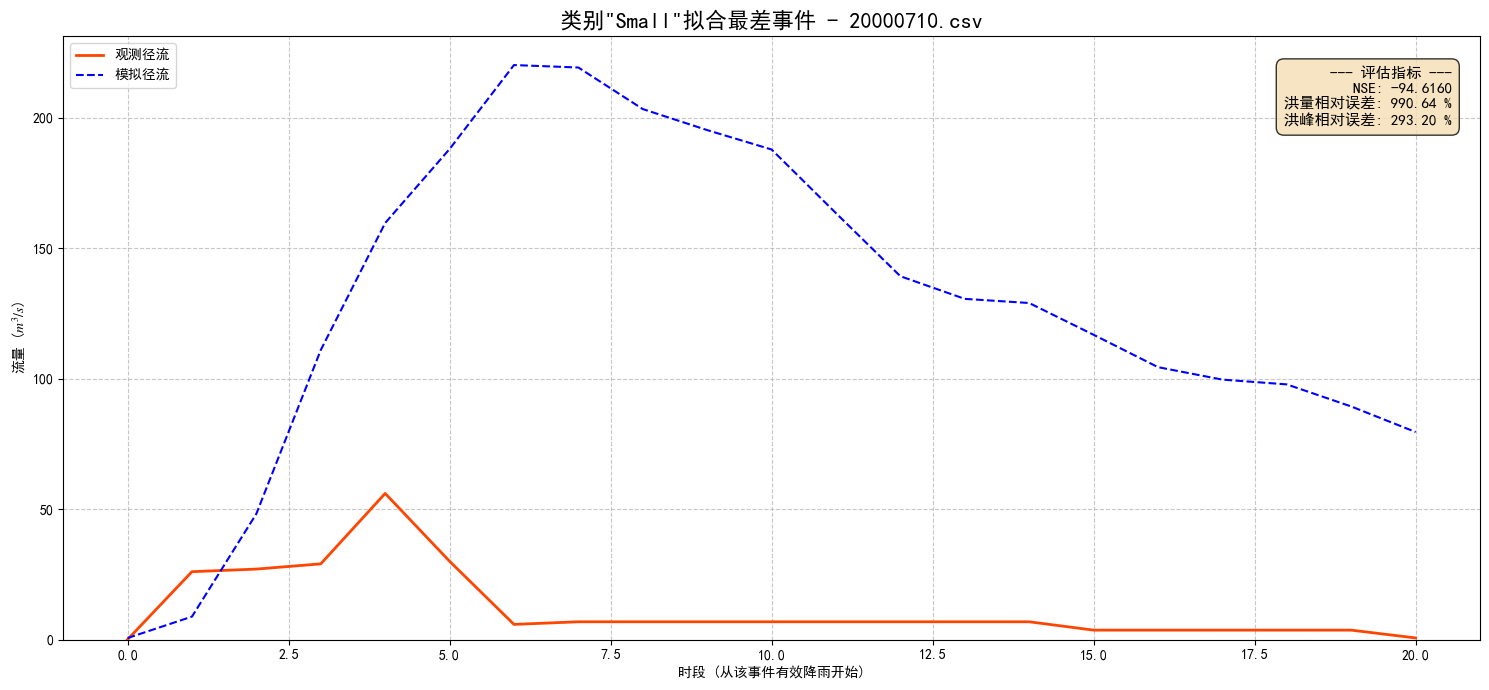

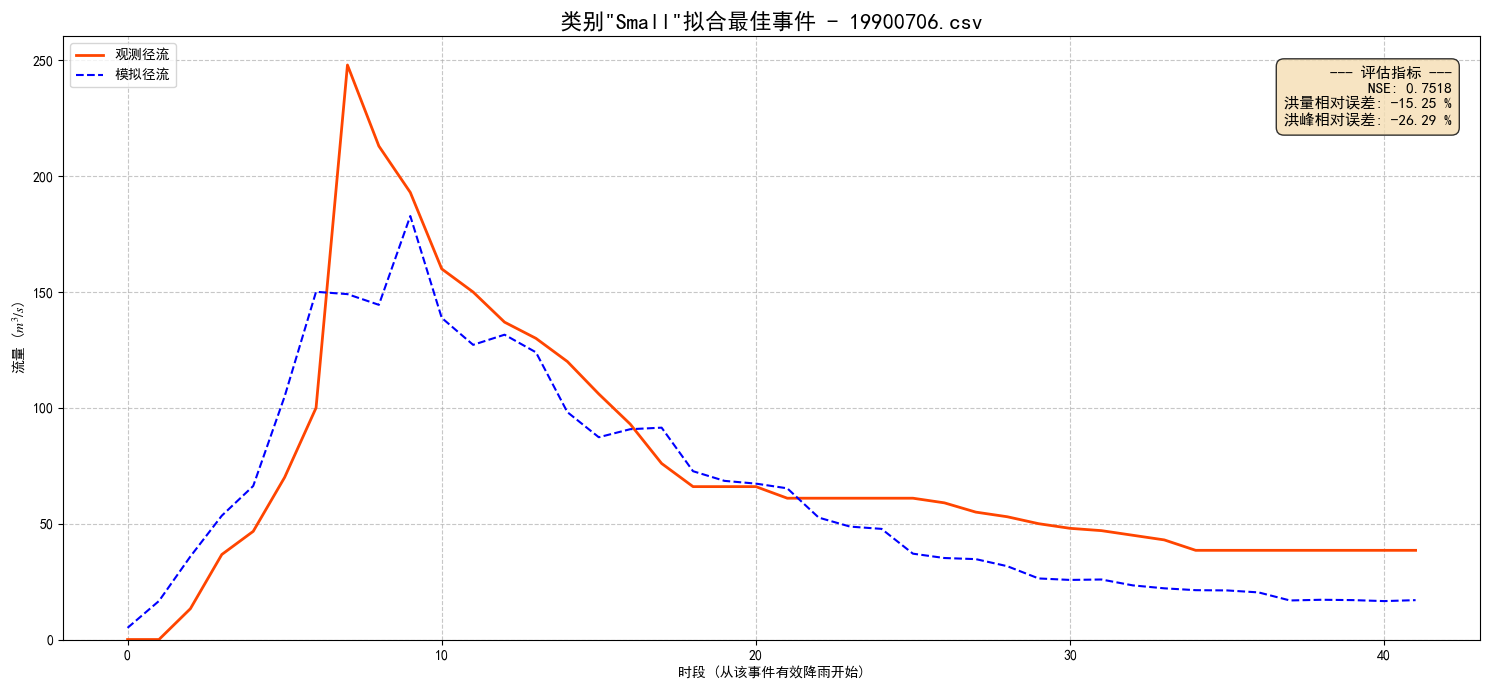


--- 正在为类别 'Medium' 绘制最佳/最差拟合图 ---


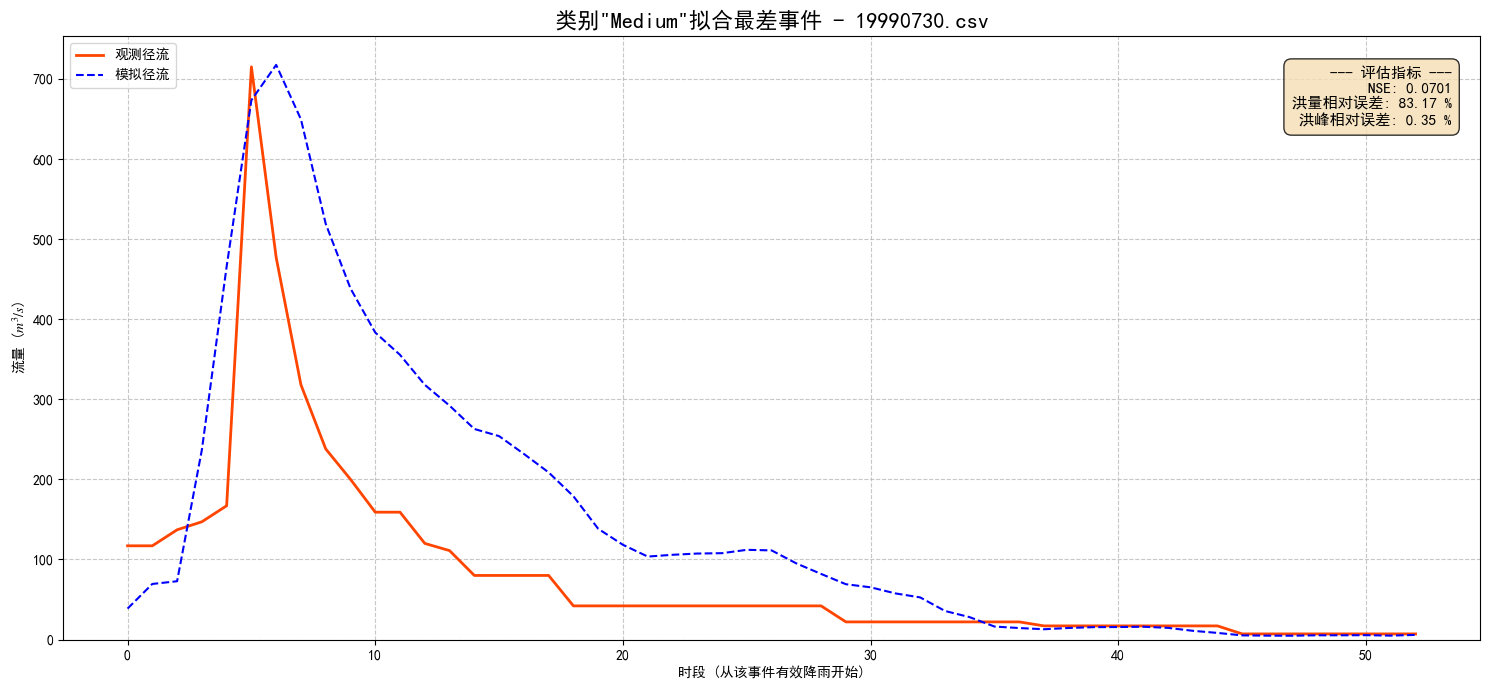

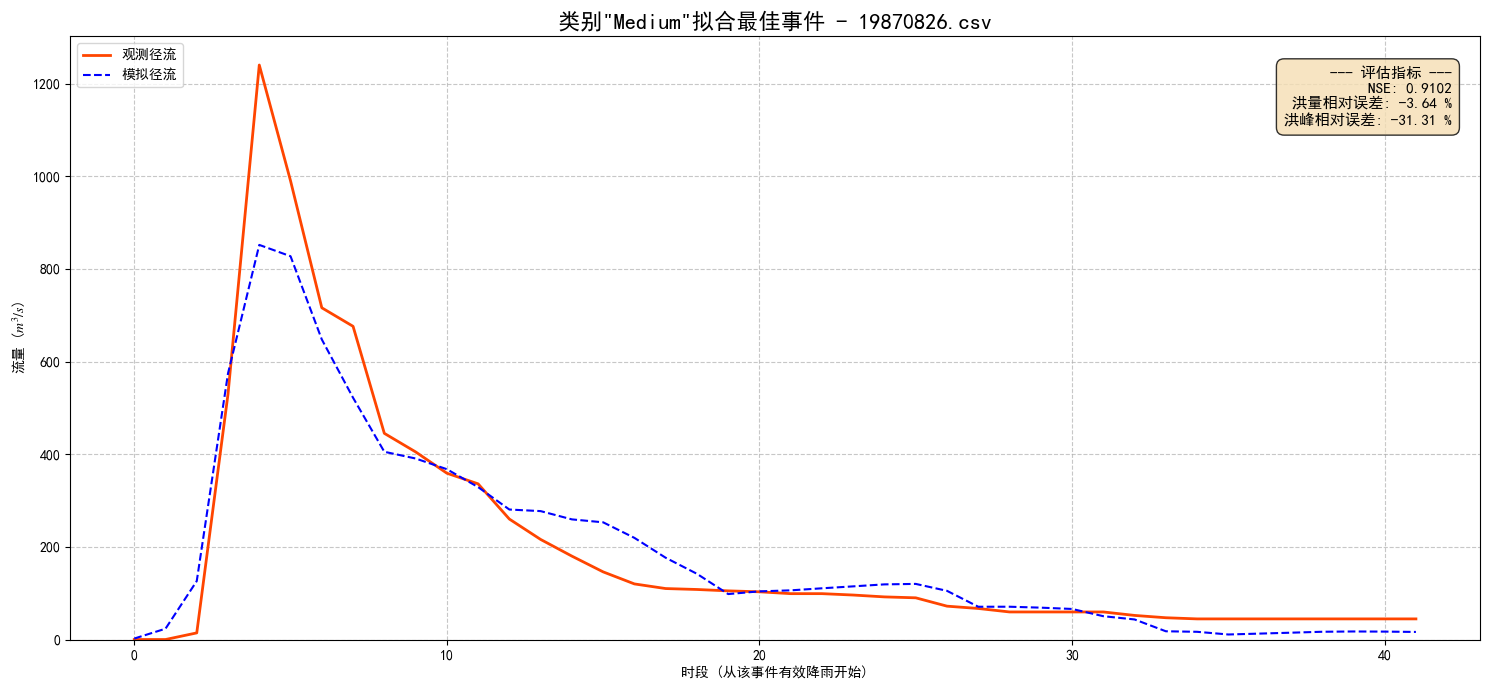


--- 正在为类别 'Large' 绘制最佳/最差拟合图 ---


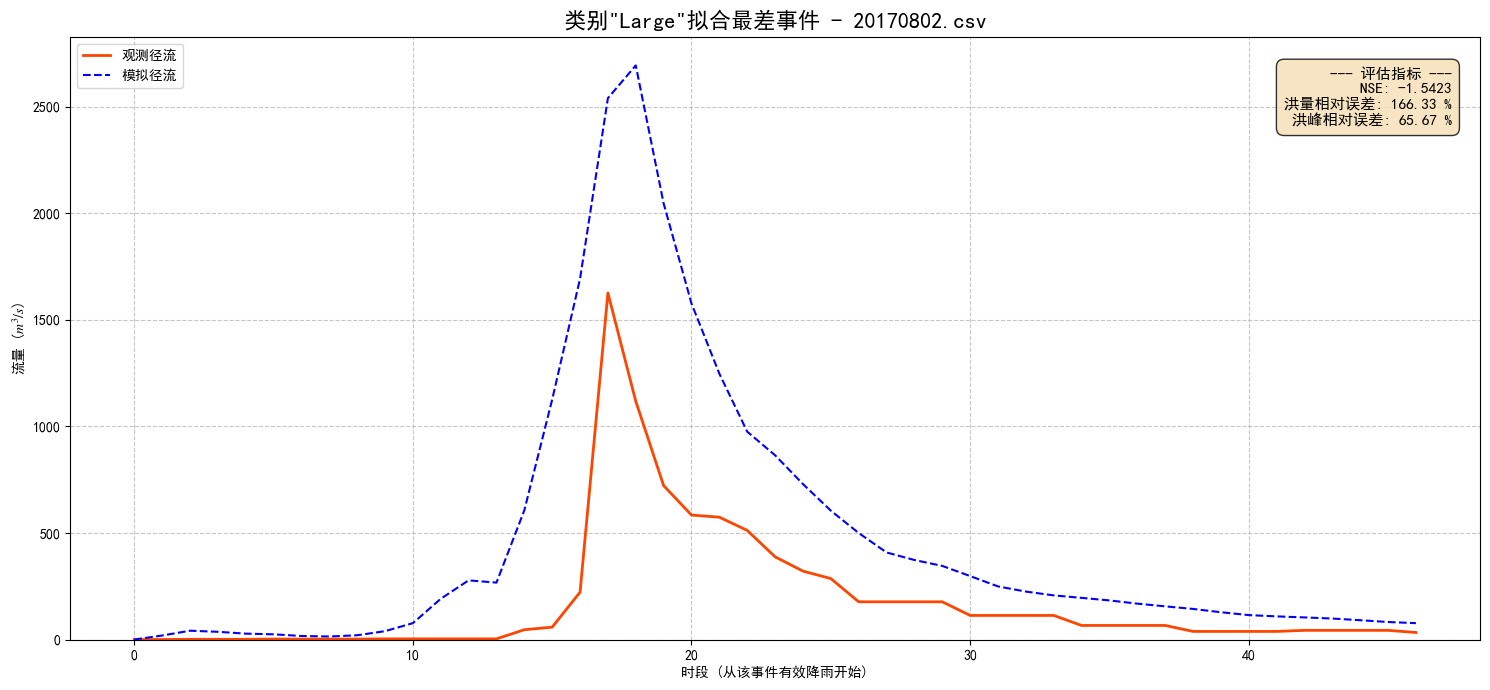

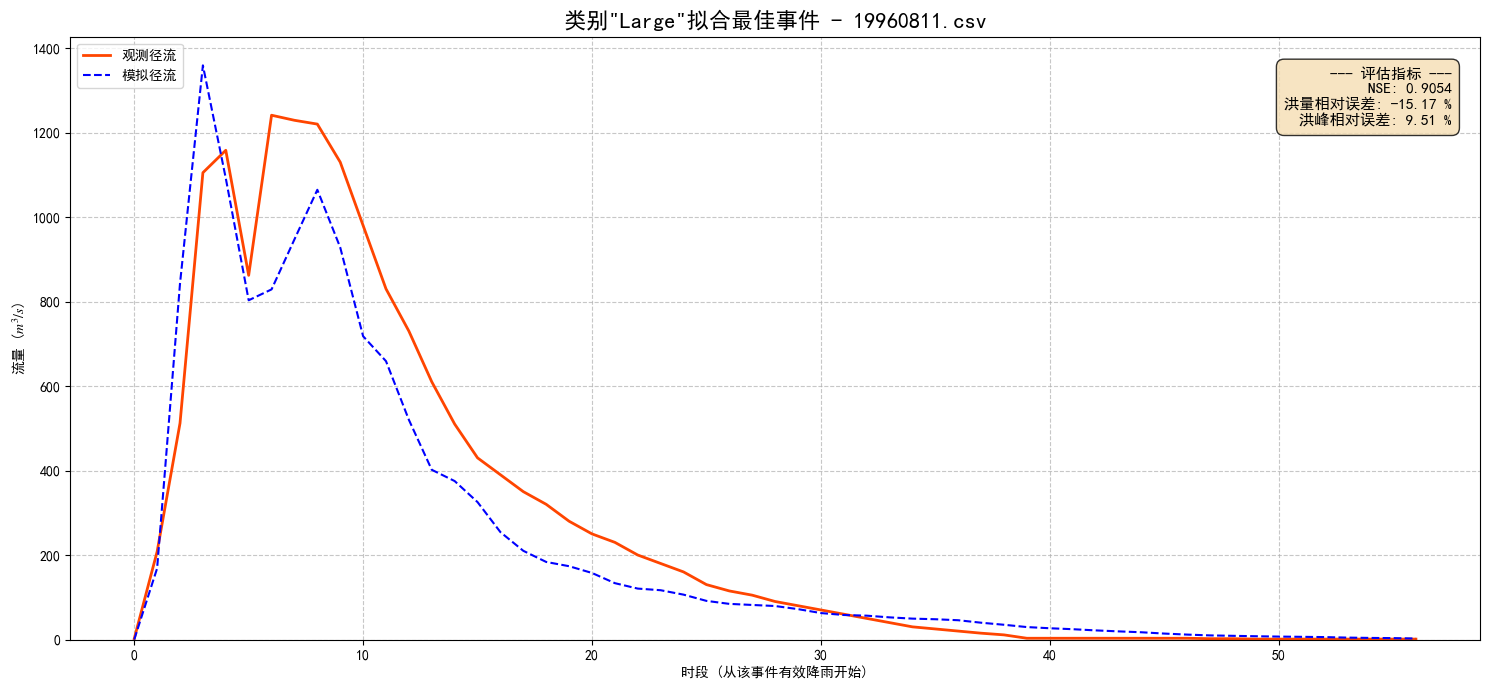

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("中文字体 SimHei 未找到，请确保已安装或修改字体设置。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 全局常量 ---
R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数 ---
def preprocess_single_event_data(csv_filepath):
    """读取并处理单个洪水事件"""
    # ... (与之前版本完全相同) ...
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None;
        for enc in encodings_to_try:
            try: df = pd.read_csv(csv_filepath, encoding=enc); break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None
    time_col, net_rain_col, direct_runoff_col = '时间', '泰森多边形面雨量', '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None
    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    if np.sum(net_rain) < 1e-6: return None
    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain):
        if r_val > 1e-6: first_rain_idx, has_effective_rain = i, True; break
    if not has_effective_rain: return None
    last_rain_idx = len(net_rain) - 1
    for i in range(len(net_rain) - 1, first_rain_idx - 1, -1):
        if net_rain[i] > 1e-6: last_rain_idx = i; break
    P_eff_event = net_rain[first_rain_idx : last_rain_idx + 1]
    m_eff_event = len(P_eff_event)
    if m_eff_event == 0: return None
    Q_obs_eff_event = direct_runoff[first_rain_idx:]
    l_obs_eff_event = len(Q_obs_eff_event)
    n_event_specific = l_obs_eff_event - m_eff_event + 1
    if n_event_specific <= 0: return None
    peak_flow = np.max(direct_runoff)
    if peak_flow < 1e-6: return None
    return {"P_eff": P_eff_event, "Q_obs_eff": Q_obs_eff_event, "m_eff": m_eff_event, 
            "n_specific": n_event_specific, "filepath": csv_filepath, "peak_obs": peak_flow}

def convolve_uh(P, U, R_UH_val):
    """离散卷积函数"""
    # ... (与之前版本完全相同) ...
    m_p, n_u = len(P), len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh_for_category):
    """多事件目标函数"""
    # ... (与之前版本完全相同) ...
    total_fit_loss = 0
    if len(U_params) != common_n_uh_for_category: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

def optimize_uh_for_group(events_in_group, group_name, weights):
    """对指定事件组进行单位线优化"""
    # ... (与之前版本完全相同) ...
    print(f"\n--- 正在为组 '{group_name}' 优化特征单位线 ({len(events_in_group)} 场) ---")
    if len(events_in_group) < 3:
        print("事件数量过少，跳过优化。")
        return None
    n_specifics = [d["n_specific"] for d in events_in_group if d["n_specific"] > 0]
    if not n_specifics: return None
    n_uh_group = int(np.max(n_specifics))
    if n_uh_group <= 1: n_uh_group = max(3, n_uh_group if n_uh_group > 0 else 3)
    print(f"  单位线长度: {n_uh_group}")
    data_for_opt_group = []
    for event in events_in_group:
        P_eff, Q_obs_eff, m_eff = event["P_eff"], event["Q_obs_eff"], event["m_eff"]
        target_q_len = m_eff + n_uh_group - 1
        if target_q_len < 0: target_q_len = 0
        Q_obs_for_opt = np.zeros(target_q_len)
        len_to_copy = min(len(Q_obs_eff), target_q_len)
        Q_obs_for_opt[:len_to_copy] = Q_obs_eff[:len_to_copy]
        data_for_opt_group.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt})
    U_initial = np.zeros(n_uh_group)
    bounds = [(0, None) for _ in range(n_uh_group)]
    smoothing, peak_penalty = weights['smoothing_factor'], weights['peak_violation_weight']
    apply_penalty = n_uh_group > 2
    print(f"  使用权重: 平滑={smoothing}, 单峰罚={peak_penalty if apply_penalty else 'N/A'}")
    result_uh = minimize(objective_function_multi_event, U_initial, args=(data_for_opt_group, R_UH, smoothing, peak_penalty, apply_penalty, n_uh_group), method='L-BFGS-B', bounds=bounds, options={'disp': False, 'maxiter': 500})
    U_optimized = result_uh.x if (result_uh.success or result_uh.status in [0,2]) else None
    status_message = "成功" if (result_uh.success or result_uh.status in [0,2]) else "可能未收敛"
    print(f"  优化{status_message}")
    return U_optimized

# --- 修改后的绘图函数 ---
def plot_fit_comparison_with_metrics(event_data, U_optimized, plot_title, metrics):
    """为单个事件绘制拟合对比图，并标注NSE, 洪峰误差, 洪量误差"""
    P_event, Q_obs_event = event_data["P_eff"], event_data["Q_obs_eff"]
    event_filename = os.path.basename(event_data["filepath"])
    
    Q_sim_full = convolve_uh(P_event, U_optimized, R_UH)
    Q_sim_plot = Q_sim_full[:len(Q_obs_event)]
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # 绘制曲线 (与之前版本相同)
    ax.plot(np.arange(len(Q_obs_event)), Q_obs_event, label='观测径流', color='orangered', linewidth=2)
    ax.plot(np.arange(len(Q_sim_plot)), Q_sim_plot, label=f'模拟径流', color='blue', linestyle='--')
    
    # 准备并标注文本框
    info_text = (
        f"--- 评估指标 ---\n"
        f"NSE: {metrics['NSE']:.4f}\n"
        f"洪量相对误差: {metrics['volume_rel_error']:.2f} %\n"
        f"洪峰相对误差: {metrics['peak_rel_error']:.2f} %"
    )
    props = dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.95, info_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
    # 美化图表
    ax.set_title(f'{plot_title} - {event_filename}', fontsize=16)
    ax.set_xlabel('时段 (从该事件有效降雨开始)')
    ax.set_ylabel(r'流量 ($m^3/s$)')
    ax.legend(loc='upper left'); 
    ax.grid(True, linestyle='--', alpha=0.7); 
    ax.set_ylim(bottom=0); 
    plt.tight_layout(); 
    plt.show()

# --- 主程序 ---
# 1. & 2. & 3. 数据准备、分类和单位线优化 (与之前版本相同)
data_folder = "data_source/" 
try:
    csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
    if not csv_files: exit()
except FileNotFoundError: exit()
all_events_processed_data = [d for d in [preprocess_single_event_data(f) for f in csv_files] if d]
if not all_events_processed_data: exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

event_peaks = [data['peak_obs'] for data in all_events_processed_data if data['peak_obs'] > 0]
if not event_peaks: exit()
threshold_low = np.percentile(event_peaks, 33.3)
threshold_high = np.percentile(event_peaks, 66.6)
categorized_events = {'small': [], 'medium': [], 'large': []}
for event_data in all_events_processed_data:
    peak = event_data['peak_obs']
    if peak <= threshold_low: categorized_events['small'].append(event_data)
    elif peak <= threshold_high: categorized_events['medium'].append(event_data)
    else: categorized_events['large'].append(event_data)
print("\n各类别洪水事件数量:")
for category, events in categorized_events.items(): print(f"  {category.capitalize()} 洪水: {len(events)} 场")

category_weights = {
    'small':  {'smoothing_factor': 0.1, 'peak_violation_weight': 100.0},
    'medium': {'smoothing_factor': 0.5, 'peak_violation_weight': 500.0},
    'large':  {'smoothing_factor': 1.0, 'peak_violation_weight': 1000.0}
}
optimized_uhs = {}
for category_name, events in categorized_events.items():
    weights = category_weights.get(category_name, {})
    optimized_uhs[category_name] = optimize_uh_for_group(events, category_name, weights)

# 4. 评估并为每个类别绘制最差和最好的拟合图
for category_name, events_in_category in categorized_events.items():
    U_optimized_cat = optimized_uhs.get(category_name)
    if U_optimized_cat is None:
        print(f"\n类别 '{category_name}' 没有可用的特征单位线，跳过绘图。")
        continue

    # --- 核心修改：计算每个事件的详细指标 ---
    category_event_analysis = []
    for event_data in events_in_category:
        P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
        Q_sim_event_full = convolve_uh(P_event, U_optimized_cat, R_UH)
        Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
        
        # 初始化指标
        nse = np.nan; volume_rel_error = np.nan; peak_rel_error = np.nan
        
        if len(Q_obs_event_full) > 0 and len(Q_sim_event_compare) == len(Q_obs_event_full):
            # NSE
            mean_obs = np.mean(Q_obs_event_full)
            den_nse = np.sum((Q_obs_event_full - mean_obs)**2)
            if den_nse == 0: nse = 1.0 if np.allclose(Q_sim_event_compare, Q_obs_event_full) else -np.inf
            else: nse = 1 - (np.sum((Q_obs_event_full - Q_sim_event_compare)**2) / den_nse)
            
            # 洪量相对误差
            vol_obs = np.sum(Q_obs_event_full) * delta_t_seconds
            vol_sim = np.sum(Q_sim_event_compare) * delta_t_seconds
            if vol_obs > 1e-6: volume_rel_error = ((vol_sim - vol_obs) / vol_obs) * 100.0
                
            # 洪峰相对误差
            peak_obs = np.max(Q_obs_event_full)
            peak_sim = np.max(Q_sim_event_compare)
            if peak_obs > 1e-6: peak_rel_error = ((peak_sim - peak_obs) / peak_obs) * 100.0

        category_event_analysis.append({
            "filepath": event_data["filepath"], 
            "NSE": nse,
            "volume_rel_error": volume_rel_error,
            "peak_rel_error": peak_rel_error
        })

    # 按NSE从小到大排序
    category_event_analysis_sorted = sorted(
        category_event_analysis, 
        key=lambda x: x["NSE"] if pd.notna(x["NSE"]) and np.isfinite(x["NSE"]) else float('-inf')
    )
    
    # 筛选出有效的评估结果
    valid_results = [res for res in category_event_analysis_sorted if pd.notna(res["NSE"]) and np.isfinite(res["NSE"])]

    if len(valid_results) > 0:
        print(f"\n--- 正在为类别 '{category_name.capitalize()}' 绘制最佳/最差拟合图 ---")
        
        # 获取并绘制拟合效果最差的一场
        worst_fit_event_info = valid_results[0]
        worst_event_data = next((data for data in events_in_category if data["filepath"] == worst_fit_event_info["filepath"]), None)
        if worst_event_data:
            plot_fit_comparison_with_metrics(
                worst_event_data, U_optimized_cat, 
                f'类别"{category_name.capitalize()}"拟合最差事件', 
                worst_fit_event_info # 传递包含所有指标的字典
            )

        # 获取并绘制拟合效果最好的一场 (如果多于一场)
        if len(valid_results) > 1:
            best_fit_event_info = valid_results[-1]
            best_event_data = next((data for data in events_in_category if data["filepath"] == best_fit_event_info["filepath"]), None)
            if best_event_data:
                plot_fit_comparison_with_metrics(
                    best_event_data, U_optimized_cat, 
                    f'类别"{category_name.capitalize()}"拟合最佳事件', 
                    best_fit_event_info # 传递包含所有指标的字典
                )
        elif len(valid_results) == 1:
             print(f"  (类别 '{category_name.capitalize()}' 只有一个有效事件，因此最佳和最差是同一个)")
    else:
        print(f"类别 '{category_name}' 没有可供评估的有效洪水事件。")